# Summary
In this notebook we extract info about parent masses from the GNPS library (downloaded locally), and from a dataset from Cruesemann et al. (2017) (downloaded locally).

Layout:
- Reading in GNPS data
- Sketching ideas
- Loading and cleaning the Cruesemann data
- Finalising the figure about parent mass distributions

In [235]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spec2vec.vector_operations import calc_vector
from collections import OrderedDict, Counter
import seaborn as sns
from tqdm.notebook import tqdm

plt.rcParams['svg.fonttype'] = 'none'  # default is 'path' which converts text to path, 'none' keeps text as text
# note: this might cause some interpreters of svgs to not be able to load them though

## Reading in GNPS data
GNPS data accessed 15-12-2021 and cleaned with matchms, see https://github.com/iomega/ms2query/tree/main/notebooks/Analysis_with_dataset_GNPS_15_12_2021/data_processing_and_training_models.

In [236]:
data_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/GNPS_15_12_21/"

base = "ALL_GNPS_15_12_2021"
spectrum_file = os.path.join(data_path, base+"_positive_annotated.pickle")
spectrum_file_unan = os.path.join(data_path, base+"_positive_not_annotated.pickle")
[os.path.exists(s_file) for s_file in (spectrum_file, spectrum_file_unan)]

[True, True]

In [237]:
spectrums = pickle.load(open(spectrum_file, 'rb'))
print(len(spectrums))

314318


In [238]:
spectrums_unan = pickle.load(open(spectrum_file_unan, 'rb'))
print(len(spectrums_unan))

13908


In [240]:
masses = [s.metadata.get('parent_mass') for s in spectrums]
print(len(masses))
masses = [s for s in masses if s]  # remove specs without annotated parent_mass?
print('Spectra with parent_mass:', len(masses))

314318
Spectra with parent_mass: 314318


In [241]:
masses_unan = [s.metadata.get('parent_mass') for s in spectrums_unan]
print(len(masses_unan))
masses_unan = [s for s in masses_unan if s]  # remove specs without annotated parent_mass?
print('Spectra (unannotated) with parent_mass:', len(masses_unan))

13908
Spectra (unannotated) with parent_mass: 13908


In [242]:
print(min(masses), max(masses))

-0.00727600000000006 3498.612724


In [243]:
#unannotated
print(min(masses_unan), max(masses_unan))

-22.989218 2699.152724


In [244]:
cutoff = 2000
len([m for m in masses if m >= cutoff]), len([m for m in masses if m >= cutoff])/len(masses)*100

(776, 0.24688372921690774)

## Sketching

[-1.000e+00  4.900e+01  9.900e+01  1.490e+02  1.990e+02  2.490e+02
  2.990e+02  3.490e+02  3.990e+02  4.490e+02  4.990e+02  5.490e+02
  5.990e+02  6.490e+02  6.990e+02  7.490e+02  7.990e+02  8.490e+02
  8.990e+02  9.490e+02  9.990e+02  1.049e+03  1.099e+03  1.149e+03
  1.199e+03  1.249e+03  1.299e+03  1.349e+03  1.399e+03  1.449e+03
  1.499e+03  1.549e+03  1.599e+03  1.649e+03  1.699e+03  1.749e+03
  1.799e+03  1.849e+03  1.899e+03  1.949e+03  1.999e+03  2.049e+03
  2.099e+03  2.149e+03  2.199e+03  2.249e+03  2.299e+03  2.349e+03
  2.399e+03  2.449e+03  2.499e+03  2.549e+03  2.599e+03  2.649e+03
  2.699e+03  2.749e+03  2.799e+03  2.849e+03  2.899e+03  2.949e+03
  2.999e+03  3.049e+03  3.099e+03  3.149e+03  3.199e+03  3.249e+03
  3.299e+03  3.349e+03  3.399e+03  3.449e+03  3.499e+03]


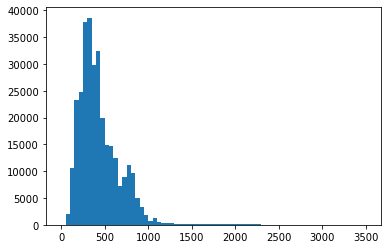

In [245]:
bins = np.arange(-1, max(masses)+50, 50)
print(bins)
plt.hist(masses, bins=bins)
plt.show()

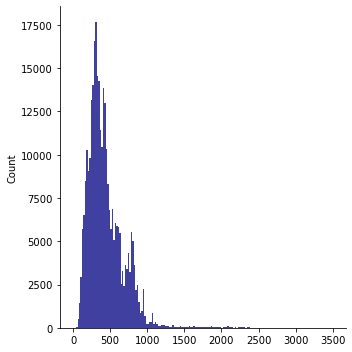

In [246]:
clamshell_colours = ['#000080', '#313194', '#6161A8', '#7A7AB2']
col = clamshell_colours[0]
step=20
bins = np.arange(-1, max(masses)+step, step)
# print(bins)
h = sns.displot(masses, bins=bins, color=col, kde=False, linewidth=0)
plt.show()

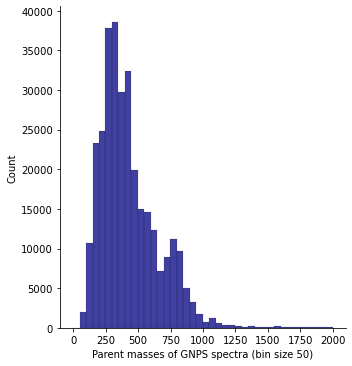

In [247]:
clamshell_colours = ['#000080', '#313194', '#6161A8', '#7A7AB2']
col = clamshell_colours[0]
step=50
max_b = 2000
bins = np.arange(-1, max_b, step)
# print(bins)
h = sns.displot(masses, bins=bins, color=col, kde=False, linewidth=0.1)
plt.xlabel(f"Parent masses of GNPS spectra (bin size {step})")
plt.savefig(
    f"/mnt/scratch/louwe015/Mass_differences/ALL_GNPS_15_12_2021_positive_annotated_masses_binsize{step}_max{max_b}.svg")

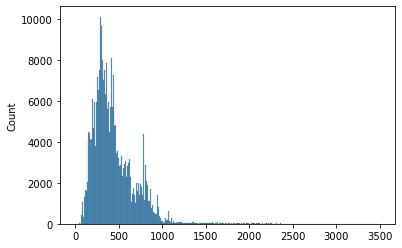

In [248]:
step=10
bins = np.arange(-1, max(masses)+step, step)
# print(bins)
h10 = sns.histplot(masses, bins=bins)
plt.show()

### Dereplicated on inchikey

In [249]:
import sys
sys.path.append('../scripts')
from mass_differences.processing import get_ids_for_unique_inchikeys
uniq_ids = get_ids_for_unique_inchikeys(spectrums)

In [250]:
masses_ui = [spectrums[i].metadata.get('parent_mass') for i in uniq_ids]
print(len(masses_ui))
masses_ui = [s for s in masses_ui if s]  # remove specs without annotated parent_mass?
print('Spectra (best one per inchikey_14) with parent_mass:', len(masses_ui))

20889
Spectra (best one per inchikey_14) with parent_mass: 20889


In [251]:
print(min(masses_ui), max(masses_ui))

-0.00727600000000006 3437.5654470960185


In [252]:
len([m for m in masses_ui if m < 600])/len(masses_ui)*100

83.42189669203887

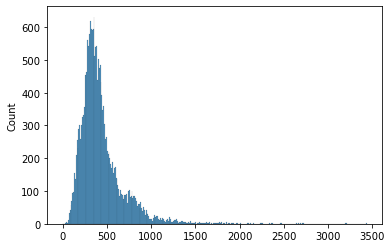

In [253]:
step =10
bins = np.arange(-1, max(masses_ui)+step, step)
# print(bins)
sns.histplot(masses_ui, bins=bins)
plt.show()

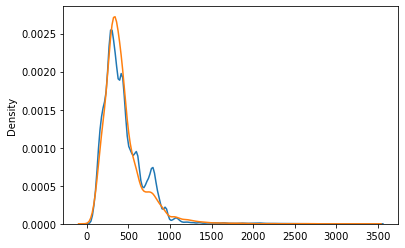

In [254]:
step =10
bins = np.arange(-1, max(masses)+step, step)
fig = sns.kdeplot(masses)
fig = sns.kdeplot(masses_ui)
plt.show()

## Cleaning up Cruesemann data

In [255]:
# from gnps the mgf for the MN with id: 9ba6f1296adb494db4dac117110a420a
from matchms.importing import load_from_mgf
mgf_path = "/mnt/scratch/louwe015/NPLinker/own/nplinker_shared/crusemann_3ids_AS6-AS3_30-11/METABOLOMICS-SNETS-V2-9ba6f129-download_clustered_spectra-main.mgf"
crus_spectra_raw = list(load_from_mgf(mgf_path))

In [256]:
print('Number of imported crusemann spectra:', len(crus_spectra_raw))

Number of imported crusemann spectra: 246833


In [257]:
def count_annotations(spectra):
    """Function to keep track of the amount of annotated spectra."""
    inchi_lst = []
    smiles_lst = []
    inchikey_lst = []
    nr_of_spectra_with_less_than_3_peaks = 0
    nr_of_spectra_with_more_than_500_peaks = 0

    for i, spec in enumerate(spectra):
        inchi_lst.append(spec.get("inchi"))
        smiles_lst.append(spec.get("smiles"))
        inchikey = spec.get("inchikey")
        if inchikey is None:
            inchikey = spec.get("inchikey_inchi")
        inchikey_lst.append(inchikey)
        if len(spec.peaks.mz) < 3:
            nr_of_spectra_with_less_than_3_peaks += 1
        if len(spec.peaks.mz) > 500:
            nr_of_spectra_with_more_than_500_peaks += 1

    inchi_count = sum([1 for x in inchi_lst if x])
    smiles_count = sum([1 for x in smiles_lst if x])
    inchikey_count = sum([1 for x in inchikey_lst if x])
    print("nr_of_spectra:", len(spectra))
    print("Inchis:", inchi_count, "--", len(set(inchi_lst)), "unique")
    print("Smiles:", smiles_count, "--", len(set(smiles_lst)), "unique")
    print("Inchikeys:", inchikey_count, "--", 
          len(set([x[:14] for x in inchikey_lst if x])), "unique (first 14 characters)")
    print("Spectra with less than 3 peaks:", nr_of_spectra_with_less_than_3_peaks)
    print("Spectra with more than 500 peaks:", nr_of_spectra_with_more_than_500_peaks)

In [258]:
count_annotations(crus_spectra_raw)

nr_of_spectra: 246833
Inchis: 0 -- 1 unique
Smiles: 0 -- 1 unique
Inchikeys: 0 -- 0 unique (first 14 characters)
Spectra with less than 3 peaks: 233166
Spectra with more than 500 peaks: 0


In [259]:
import matchms.filtering as msfilters
print(msfilters.default_filters.__doc__)


    Collection of filters that are considered default and that do no require any (factory) arguments.

    Collection is

    1. :meth:`~matchms.filtering.make_charge_scalar`
    2. :meth:`~matchms.filtering.make_ionmode_lowercase`
    3. :meth:`~matchms.filtering.set_ionmode_na_when_missing`
    4. :meth:`~matchms.filtering.add_compound_name`
    5. :meth:`~matchms.filtering.derive_adduct_from_name`
    6. :meth:`~matchms.filtering.derive_formula_from_name`
    7. :meth:`~matchms.filtering.clean_compound_name`
    8. :meth:`~matchms.filtering.add_precursor_mz`
    9. :meth:`~matchms.filtering.derive_ionmode`
    10. :meth:`~matchms.filtering.correct_charge`

    


In [260]:
def apply_metadata_filters(s):
    # Default filters
    s = msfilters.default_filters(s)
    s = msfilters.derive_adduct_from_name(s)
    s = msfilters.add_parent_mass(s, estimate_from_adduct=True)
    
    # Here, undefiend entries will be harmonized (instead of having a huge variation of None,"", "N/A" etc.)
    s = msfilters.harmonize_undefined_inchikey(s)
    s = msfilters.harmonize_undefined_inchi(s)
    s = msfilters.harmonize_undefined_smiles(s)

    # The repair_inchi_inchikey_smiles function will correct misplaced metadata (e.g. inchikeys entered as inchi etc.) and harmonize the entry strings.
    s = msfilters.repair_inchi_inchikey_smiles(s)

    # Where possible (and necessary, i.e. missing): Convert between smiles, inchi, inchikey to complete metadata. This is done using functions from rdkit.
    s = msfilters.derive_inchi_from_smiles(s)
    s = msfilters.derive_smiles_from_inchi(s)
    s = msfilters.derive_inchikey_from_inchi(s)
    return s



In [261]:
crus_spectra = [apply_metadata_filters(s) for s in tqdm(crus_spectra_raw)]

  0%|          | 0/246833 [00:00<?, ?it/s]

In [262]:
count_annotations(crus_spectra)

nr_of_spectra: 246833
Inchis: 0 -- 1 unique
Smiles: 0 -- 1 unique
Inchikeys: 0 -- 0 unique (first 14 characters)
Spectra with less than 3 peaks: 233166
Spectra with more than 500 peaks: 0


In [263]:
# remove spectra with less than 1 peak
def normalize_and_filter_peaks(spectrum):
    spectrum = msfilters.require_minimum_number_of_peaks(spectrum, n_required=1)
    return spectrum

crus_spectra = [normalize_and_filter_peaks(s) for s in crus_spectra]
crus_spectra = [s for s in crus_spectra if s]

In [264]:
count_annotations(crus_spectra)

nr_of_spectra: 13667
Inchis: 0 -- 1 unique
Smiles: 0 -- 1 unique
Inchikeys: 0 -- 0 unique (first 14 characters)
Spectra with less than 3 peaks: 0
Spectra with more than 500 peaks: 0


In [265]:
crus_spectra_clean = [apply_metadata_filters(s) for s in tqdm(crus_spectra)]

  0%|          | 0/13667 [00:00<?, ?it/s]

In [266]:
for i, s in enumerate(crus_spectra_clean):
    prec = s.metadata.get('precursor_mz')
    par = s.metadata.get('parent_mass')
    print(s.metadata.get('charge'))
    if not par:
        print(i, prec)
        print(msfilters.correct_charge(s).metadata)
        print(msfilters.add_parent_mass(s, estimate_from_adduct=True).metadata)
        break

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
18 299.99701
{'pepmass': (299.99701, None), 'charge': 0, 'mslevel': '2', 'precursorintensity': '73488.000000', 'filename': 'specs_ms.pklbin', 'rtinseconds': 345.578003, 'activation': 'CID', 'instrument': 'ion trap', 'title': 'Scan Number: 45', 'scans': '45', 'ionmode': 'n/a', 'compound_name': 'Scan Number: 45', 'precursor_mz': 299.99701, 'parent_mass': 0.0, 'inchikey': '', 'inchi': '', 'smiles': ''}
{'pepmass': (299.99701, None), 'charge': 0, 'mslevel': '2', 'precursorintensity': '73488.000000', 'filename': 'specs_ms.pklbin', 'rtinseconds': 345.578003, 'activation': 'CID', 'instrument': 'ion trap', 'title': 'Scan Number: 45', 'scans': '45', 'ionmode': 'n/a', 'compound_name': 'Scan Number: 45', 'precursor_mz': 299.99701, 'parent_mass': 0.0, 'inchikey': '', 'inchi': '', 'smiles': ''}


In [267]:
m_query = 'parent_mass'
crus_masses = [s.metadata.get(m_query) for s in crus_spectra_clean]
print(len(crus_masses))
crus_masses = [s for s in crus_masses if s]  # remove specs without annotated parent_mass?
print('Spectra from Cruesemann data with parent_mass:', len(crus_masses))

13667
Spectra from Cruesemann data with parent_mass: 9129


In [268]:
print(min(crus_masses), max(crus_masses))

163.09971354800925 2922.5674870960183


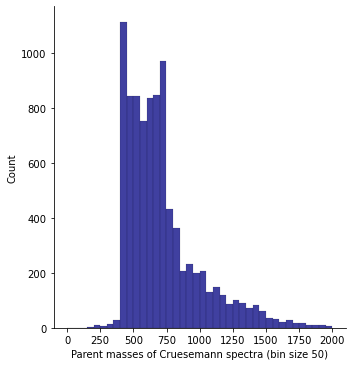

In [269]:
clamshell_colours = ['#000080', '#313194', '#6161A8', '#7A7AB2', '#DBDBDB']
col = clamshell_colours[0]
step=50
max_b = 2000
bins = np.arange(-1, max_b, step)
# print(bins)
h = sns.displot(crus_masses, bins=bins, color=col, kde=False, linewidth=0.1)
plt.xlabel(f"Parent masses of Cruesemann spectra (bin size {step})")
plt.savefig(f"/mnt/scratch/louwe015/Mass_differences/crusemann_{m_query}_binsize{step}_max{max_b}.svg")

In [270]:
h.ax.get_figure().get_size_inches()

array([5., 5.])

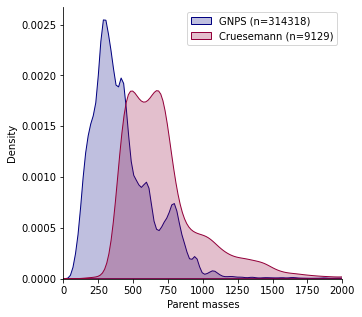

In [271]:
clamshell_div = ["#93003a"]
# step =50
# bins = np.arange(-1, max(masses)+step, step)
plt.figure(figsize=(5, 5))
max_b = 2000
fig = sns.kdeplot(masses, label=f'GNPS (n={len(masses)})', fill=True, color = clamshell_colours[0])
fig = sns.kdeplot(crus_masses, label=f'Cruesemann (n={len(crus_masses)})', fill=True, color = clamshell_div[0])
sns.despine()
plt.legend()
plt.xlabel("Parent masses")
plt.xlim(-1, max_b)
plt.savefig(f"/mnt/scratch/louwe015/Mass_differences/GNPS_vs_crusemann_{m_query}_density_max{max_b}.svg")


# Final plot

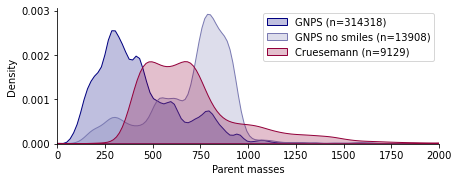

In [289]:
clamshell_div = ["#93003a"]
inch=2.54
# step =50
# bins = np.arange(-1, max(masses)+step, step)
plt.figure(figsize=(17.4/inch, 6.3517/inch))
max_b = 2000
fig = sns.kdeplot(masses, label=f'GNPS (n={len(masses)})', fill=True, color = clamshell_colours[0])
fig = sns.kdeplot(masses_unan, label=f'GNPS no smiles (n={len(masses_unan)})', fill=True, color = clamshell_colours[-2])
fig = sns.kdeplot(crus_masses, label=f'Cruesemann (n={len(crus_masses)})', fill=True, color = clamshell_div[0])

sns.despine()
plt.legend()
plt.xlabel("Parent masses")
plt.xlim(-1, max_b)
plt.savefig(f"/mnt/scratch/louwe015/Mass_differences/GNPS_vs_no_smiles_vs_crusemann_{m_query}_density_max{max_b}.svg")

## Look at the names of the spectra without SMILES
Most seem to be some kind of lipids for which they could not resolve the double bonds.

In [239]:
from collections import Counter
comp_names = Counter(s.metadata.get('compound_name') for s in spectrums_unan)

print(len(comp_names))
comp_names.most_common()

3512


[('PC(16:0/18:1)', 286),
 ('PC(18:0/18:1)', 216),
 ('PC(18:2/0:0)', 202),
 ('PC(0:0/20:4)', 175),
 ('TG(16:0/16:0/18:1)', 152),
 ('TG(18:1/18:1/18:1)', 108),
 ('Cer(d18:1/24:1)', 96),
 ('CoQ9', 94),
 ('PC(15:0/18:1)', 92),
 ('GalCer(d18:1/18:1)', 90),
 ('DG(18:0/20:4/0:0)', 88),
 ('TG(16:0/18:1/22:6)', 86),
 ('PE(22:4/0:0)', 86),
 ('TG(16:0/18:1/18:2)', 84),
 ('TG(18:0/18:0/18:1)', 82),
 ('TG(15:0/16:0/18:1)', 78),
 ('PE(P-18:0/20:3)', 78),
 ('PC(22:4/0:0)', 78),
 ('PE(P-18:0/22:4)', 76),
 ('PC(17:0/18:2)', 74),
 ('TG(16:1/18:1/18:1)', 72),
 ('TG(16:1/16:1/18:1)', 68),
 ('TG(18:1/18:1/22:0)', 68),
 ('TG(17:1/18:1/18:1)', 66),
 ('PE(P-18:0/22:5)', 64),
 ('TG(14:0/16:0/18:1)', 64),
 ('PC(20:3/0:0)', 62),
 ('DG(18:2/0:0/18:2)', 60),
 ('DG(18:1/20:4/0:0)', 60),
 ('TG(18:2/18:2/20:4)', 60),
 ('TG(18:0/18:1/20:4)', 56),
 ('PC(16:1/17:1)', 54),
 ('PE(18:2/0:0)', 54),
 ('SM(d18:1/26:1)', 54),
 ('DG(18:0/18:1/0:0)', 52),
 ('TG(16:0/18:1/20:4)', 52),
 ('TG(14:0/16:1/18:1)', 52),
 ('TG(16:0/20:4/